# Прогнозирование цен потребительского ритейла по тестовой выборке на основе глубоких нейронных сетей
__Выполнил:__ *Домченко Максим*

__Студент группы:__ *РИМ-130962*

In [19]:
from pathlib import Path
from google.colab import drive

drive.mount('/content/drive')
ROOT = Path('/content/drive/MyDrive')

PROJECT_DIR = ROOT / 'price_forecasting'
DATA = PROJECT_DIR / 'data'
RAW = DATA / 'raw'
PROCESSED = DATA / 'processed'
MODELS = PROJECT_DIR / 'models'
MODELS.mkdir(exist_ok=True)

print('Проектная папка:', PROJECT_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Проектная папка: /content/drive/MyDrive/price_forecasting


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')

In [22]:
train_df = pd.read_parquet(PROCESSED / 'train_features_final.parquet')
val_df = pd.read_parquet(PROCESSED / 'val_features_final.parquet')
test_df = pd.read_parquet(PROCESSED / 'test_features_final.parquet')

print(f'Train shape: {train_df.shape}')
print(f'Validation shape: {val_df.shape}')
print(f'Test shape: {test_df.shape}')

train_df.head()

Train shape: (35743638, 22)
Validation shape: (5986318, 22)
Test shape: (6005441, 22)


,store_id,item_id,wm_yr_wk,sell_price,date,month,year,event_name_1,event_type_1,event_name_2,...,snap_TX,snap_WI,day_of_week,is_weekend,log_sell_price,event_flag,event_type_National,event_type_Cultural,event_type_Religious,event_type_Sporting
0,CA_1,FOODS_1_001,11101,2.0,2011-01-29,1,2011,NoEvent,NoEvent,NoEvent,...,0,0,5,1,1.098612,0,0,0,0,0
1,CA_1,FOODS_1_001,11101,2.0,2011-01-30,1,2011,NoEvent,NoEvent,NoEvent,...,0,0,6,1,1.098612,0,0,0,0,0
2,CA_1,FOODS_1_001,11101,2.0,2011-01-31,1,2011,NoEvent,NoEvent,NoEvent,...,0,0,0,0,1.098612,0,0,0,0,0
3,CA_1,FOODS_1_001,11101,2.0,2011-02-01,2,2011,NoEvent,NoEvent,NoEvent,...,1,0,1,0,1.098612,0,0,0,0,0
4,CA_1,FOODS_1_001,11101,2.0,2011-02-02,2,2011,NoEvent,NoEvent,NoEvent,...,0,1,2,0,1.098612,0,0,0,0,0


In [23]:
price_changes = train_df.groupby('item_id')['sell_price'].nunique().reset_index()
price_changes.columns = ['item_id', 'price_changes']
price_changes = price_changes.sort_values(by='price_changes', ascending=False)

top_10_items = price_changes.head(10)['item_id'].tolist()

print('Топ-10 товаров по числу изменений цены:', top_10_items)

price_changes.head(10)

Топ-10 товаров по числу изменений цены: ['FOODS_1_096', 'FOODS_1_129', 'FOODS_1_095', 'FOODS_1_098', 'FOODS_1_211', 'FOODS_1_147', 'FOODS_1_199', 'FOODS_1_010', 'FOODS_1_170', 'FOODS_1_087']


,item_id,price_changes
94,FOODS_1_096,44
126,FOODS_1_129,42
93,FOODS_1_095,32
96,FOODS_1_098,30
207,FOODS_1_211,28
144,FOODS_1_147,27
195,FOODS_1_199,27
8,FOODS_1_010,26
166,FOODS_1_170,26
85,FOODS_1_087,26


In [24]:
def prepare_series(df, item_id):
    df_item = df[df['item_id'] == item_id][['date', 'log_sell_price']].copy()
    df_item['date'] = pd.to_datetime(df_item['date'])
    df_item.set_index('date', inplace=True)
    return df_item.resample('D').mean().fillna(method='ffill')

train_series = {item: prepare_series(train_df, item) for item in top_10_items}
val_series = {item: prepare_series(val_df, item) for item in top_10_items}
test_series = {item: prepare_series(test_df, item) for item in top_10_items}

# Проверка одного из рядов
train_series[top_10_items[0]].head()

,log_sell_price
date,
2011-01-29,2.087514
2011-01-30,2.087514
2011-01-31,2.087514
2011-02-01,2.087514
2011-02-02,2.087514


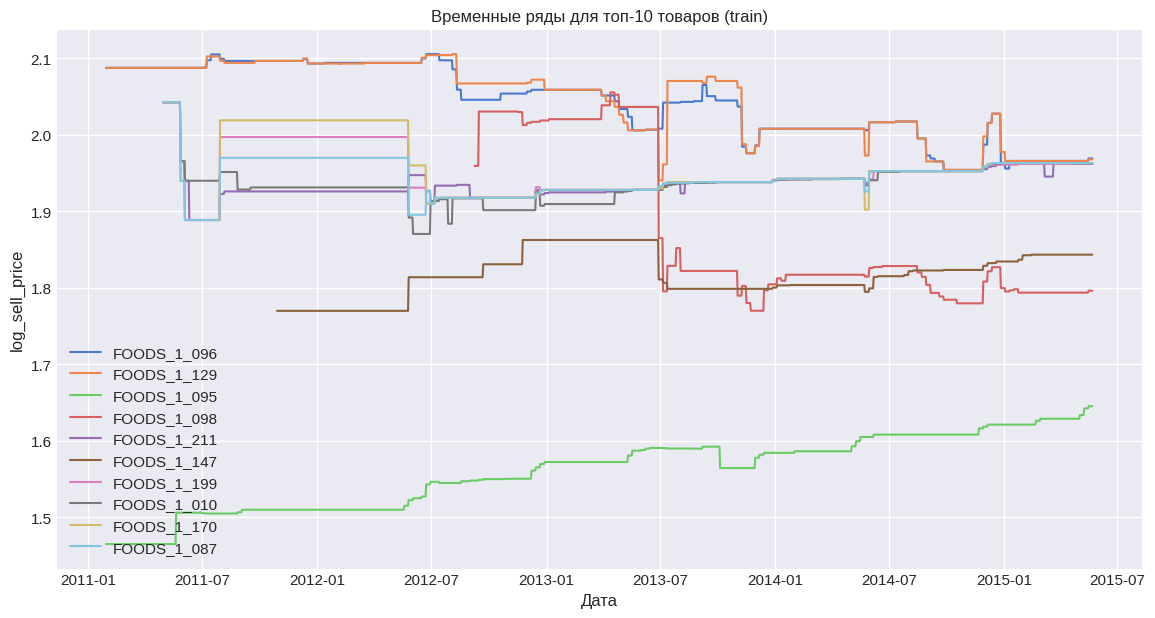

In [25]:
plt.figure(figsize=(14, 7))

for item_id in top_10_items:
    plt.plot(train_series[item_id].index, train_series[item_id], label=item_id)

plt.xlabel('Дата')
plt.ylabel('log_sell_price')
plt.title('Временные ряды для топ-10 товаров (train)')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
from statsmodels.tsa.arima.model import ARIMA

def safe_mape(y_true, y_pred, epsilon=1e-8):
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

arima_results = {}

for item_id in top_10_items:
    print(f"\nОбучение ARIMA(1,1,1) для товара: {item_id}")

    model = ARIMA(train_series[item_id], order=(1, 1, 1))
    model_fit = model.fit()

    val_forecast = model_fit.forecast(len(val_series[item_id]))
    mape = safe_mape(val_series[item_id].values, val_forecast.values)

    arima_results[item_id] = {'model': model_fit, 'val_mape': mape}

    print(f"Товар {item_id}, MAPE (валидация): {mape:.4f}%")


Обучение ARIMA(1,1,1) для товара: FOODS_1_096
Товар FOODS_1_096, MAPE (валидация): 0.4011%

Обучение ARIMA(1,1,1) для товара: FOODS_1_129
Товар FOODS_1_129, MAPE (валидация): 0.4313%

Обучение ARIMA(1,1,1) для товара: FOODS_1_095
Товар FOODS_1_095, MAPE (валидация): 4.3981%

Обучение ARIMA(1,1,1) для товара: FOODS_1_098
Товар FOODS_1_098, MAPE (валидация): 0.5340%

Обучение ARIMA(1,1,1) для товара: FOODS_1_211
Товар FOODS_1_211, MAPE (валидация): 0.5613%

Обучение ARIMA(1,1,1) для товара: FOODS_1_147
Товар FOODS_1_147, MAPE (валидация): 0.6587%

Обучение ARIMA(1,1,1) для товара: FOODS_1_199
Товар FOODS_1_199, MAPE (валидация): 0.5884%

Обучение ARIMA(1,1,1) для товара: FOODS_1_010
Товар FOODS_1_010, MAPE (валидация): 0.5687%

Обучение ARIMA(1,1,1) для товара: FOODS_1_170
Товар FOODS_1_170, MAPE (валидация): 0.5923%

Обучение ARIMA(1,1,1) для товара: FOODS_1_087
Товар FOODS_1_087, MAPE (валидация): 0.5930%


Лучший товар по MAPE: FOODS_1_096, MAPE = 0.4011%


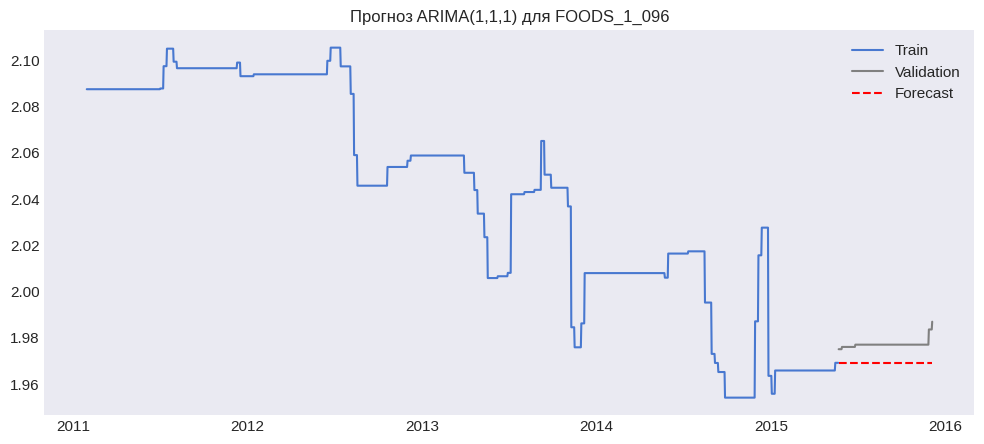

In [27]:
best_item = min(arima_results, key=lambda x: arima_results[x]['val_mape'])
print(f"Лучший товар по MAPE: {best_item}, MAPE = {arima_results[best_item]['val_mape']:.4f}%")

# Визуализация лучшего прогноза
plt.figure(figsize=(12,5))
plt.plot(train_series[best_item], label='Train')
plt.plot(val_series[best_item], label='Validation', color='gray')
plt.plot(val_series[best_item].index,
         arima_results[best_item]['model'].forecast(len(val_series[best_item])),
         label='Forecast', color='red', linestyle='--')

plt.title(f'Прогноз ARIMA(1,1,1) для {best_item}')
plt.legend()
plt.grid()
plt.show()

Финальный MAPE на тестовом наборе: 0.3434%


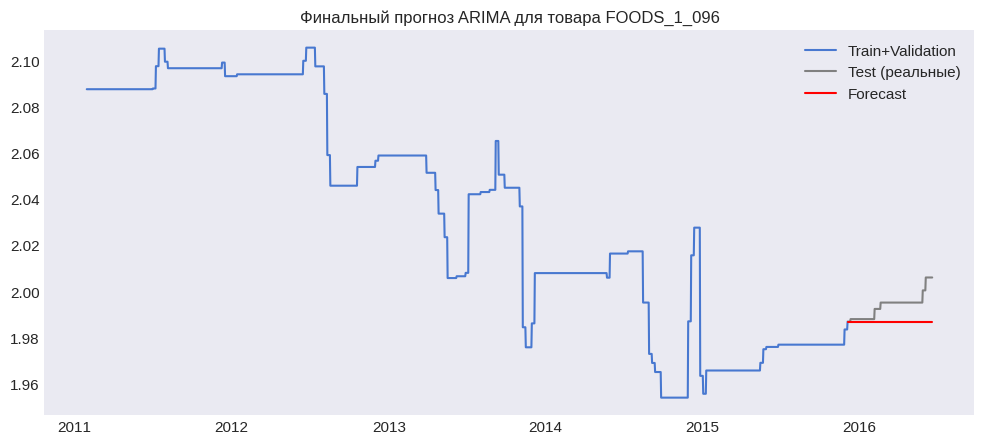

In [28]:
train_val_series = pd.concat([train_series[best_item], val_series[best_item]])

final_model = ARIMA(train_val_series, order=(1,1,1)).fit()

test_forecast = final_model.forecast(len(test_series[best_item]))
test_mape = safe_mape(test_series[best_item].values, test_forecast.values)

print(f"Финальный MAPE на тестовом наборе: {test_mape:.4f}%")

plt.figure(figsize=(12,5))
plt.plot(train_val_series, label='Train+Validation')
plt.plot(test_series[best_item], label='Test (реальные)', color='gray')
plt.plot(test_series[best_item].index, test_forecast, label='Forecast', color='red')

plt.title(f'Финальный прогноз ARIMA для товара {best_item}')
plt.legend()
plt.grid()
plt.show()

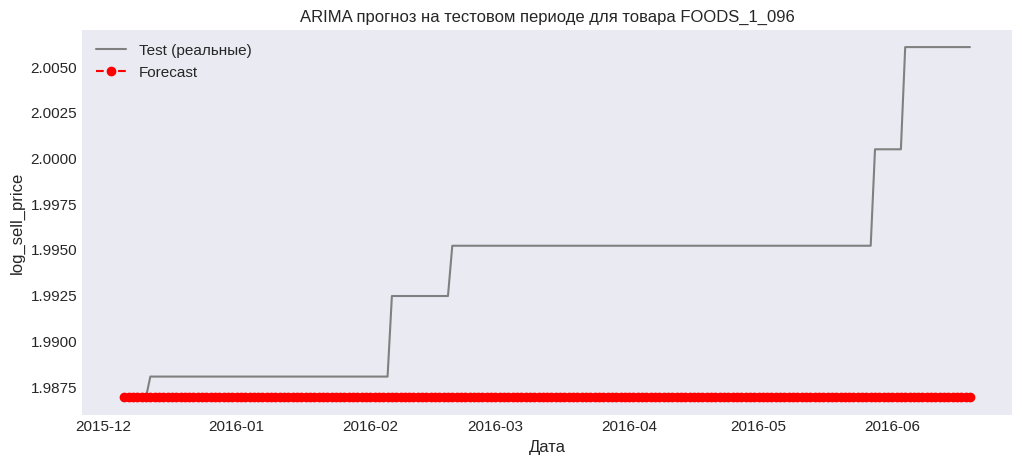

In [29]:
# Визуализация только тестового периода для лучшего товара
plt.figure(figsize=(12, 5))

plt.plot(test_series[best_item], label='Test (реальные)', color='gray')
plt.plot(test_series[best_item].index, test_forecast, label='Forecast', color='red', linestyle='--', marker='o')

plt.xlabel('Дата')
plt.ylabel('log_sell_price')
plt.title(f'ARIMA прогноз на тестовом периоде для товара {best_item}')
plt.legend()
plt.grid()
plt.show()

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(test_series[best_item], test_forecast)
mse = mean_squared_error(test_series[best_item], test_forecast)
rmse = np.sqrt(mse)
r2 = r2_score(test_series[best_item], test_forecast)

metrics = {
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'MAPE': test_mape,
    'R2': r2
}

final_model.save(MODELS / f'arima_top10_{best_item}.pkl')

with open(MODELS / f'arima_top10_{best_item}_metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)

print("Финальная модель и метрики сохранены:")
display(metrics)

Финальная модель и метрики сохранены:


{'MAE': 0.0068603508066897,
 'MSE': 7.278900996736664e-05,
 'RMSE': np.float64(0.00853164755292708),
 'MAPE': np.float64(0.34344378321106916),
 'R2': -1.8295491120703726}

### Выводы по финальному прогнозу ARIMA для товара FOODS_1_096:

- Модель ARIMA(1,1,1) дала почти постоянный прогноз, не отразив реальных изменений цены на тестовом периоде.
- Метрики (MAPE = 0.34%) формально хорошие, однако визуально модель не улавливает динамику изменения цены.
- Отрицательный показатель R² (-1.83) означает, что ARIMA дала прогноз хуже простого среднего значения, так как ряд имеет ступенчатые изменения, которые модель не способна корректно спрогнозировать.
- Такой результат указывает на ограниченные возможности ARIMA в прогнозировании товаров с редкими, но резкими изменениями цены. В таких ситуациях стоит использовать другие методы, например нейронные сети (Temporal Fusion Transformer, LSTM и т.п.).
